In [1]:
#Basic Requirements
!pip install pandas numpy matplotlib seaborn scikit-learn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [4]:
df = pd.read_csv('data_2000_to_2021.csv', sep=';')
print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Data loaded successfully!
Dataset shape: (2861, 11)
Columns: ['id', 'date', 'NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']


In [4]:
print("\nDataset info:")
df.info()

print("\nFirst few rows:")
print(df.head())

print("\nDescriptive statistics:")
print(df.describe().T)

print("\nMissing values:")
print(df.isnull().sum())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2861 non-null   int64  
 1   date       2861 non-null   object 
 2   NH4        2858 non-null   float64
 3   BSK5       2860 non-null   float64
 4   Suspended  2845 non-null   float64
 5   O2         2858 non-null   float64
 6   NO3        2860 non-null   float64
 7   NO2        2858 non-null   float64
 8   SO4        2812 non-null   float64
 9   PO4        2833 non-null   float64
 10  CL         2812 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 246.0+ KB

First few rows:
   id        date    NH4  BSK5  Suspended     O2    NO3    NO2    SO4    PO4  \
0   1  17.02.2000  0.330  2.77       12.0  12.30   9.50  0.057  154.0  0.454   
1   1  11.05.2000  0.044  3.00       51.6  14.61  17.75  0.034  352.0  0.090   
2   1  11.09.2000  0.032  2.10       

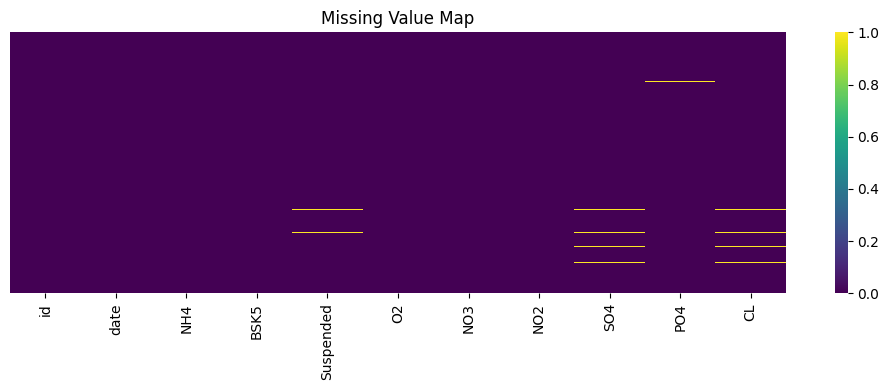

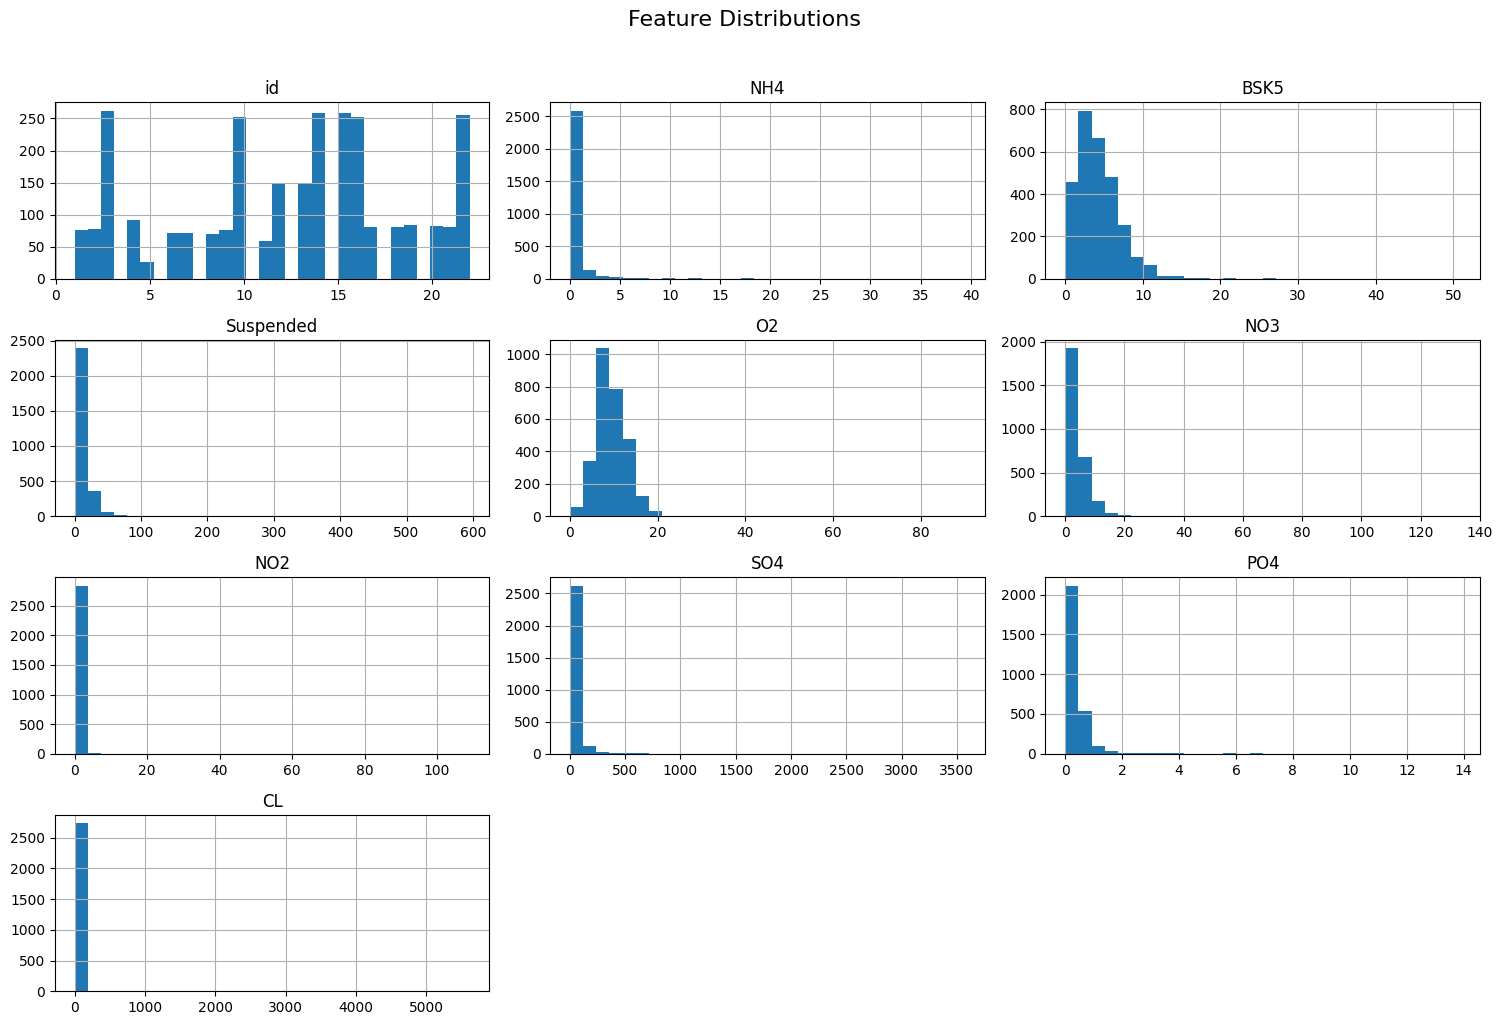

In [5]:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title("Missing Value Map")
plt.tight_layout()
plt.show()

# Feature distributions
df.hist(figsize=(15, 10), bins=30)
plt.suptitle("Feature Distributions", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

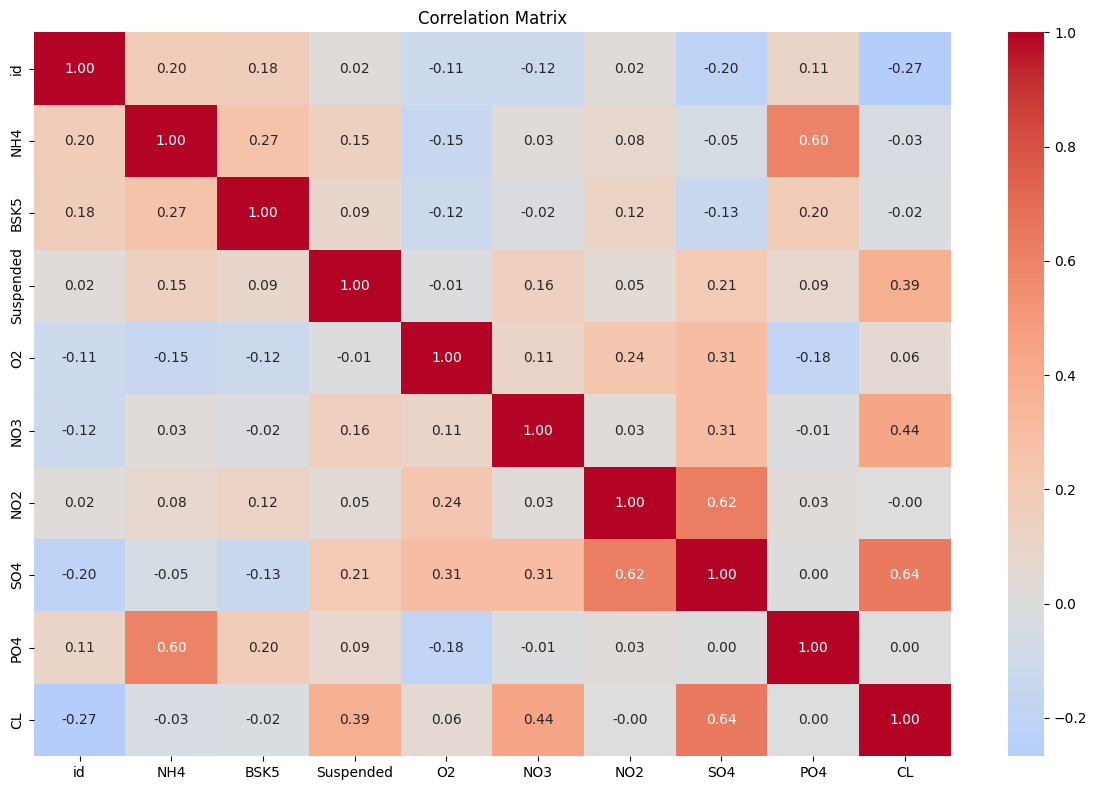

In [6]:
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [5]:
TARGET_COLS = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']

# Check if target columns exist in the dataset
existing_targets = [col for col in TARGET_COLS if col in df.columns]
if len(existing_targets) != len(TARGET_COLS):
    print(f"Warning: Some target columns not found in dataset")
    print(f"Available columns: {df.columns.tolist()}")
    print(f"Missing targets: {set(TARGET_COLS) - set(existing_targets)}")
    TARGET_COLS = existing_targets

if len(TARGET_COLS) == 0:
    raise ValueError("No target columns found in the dataset!")

print(f"Using target columns: {TARGET_COLS}")

# Check target column data types and missing values
print("\nTarget column info:")
print(df[TARGET_COLS].dtypes)
print("\nMissing values in targets:")
print(df[TARGET_COLS].isnull().sum())

Using target columns: ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']

Target column info:
NH4          float64
BSK5         float64
Suspended    float64
O2           float64
NO3          float64
NO2          float64
SO4          float64
PO4          float64
CL           float64
dtype: object

Missing values in targets:
NH4           3
BSK5          1
Suspended    16
O2            3
NO3           1
NO2           3
SO4          49
PO4          28
CL           49
dtype: int64


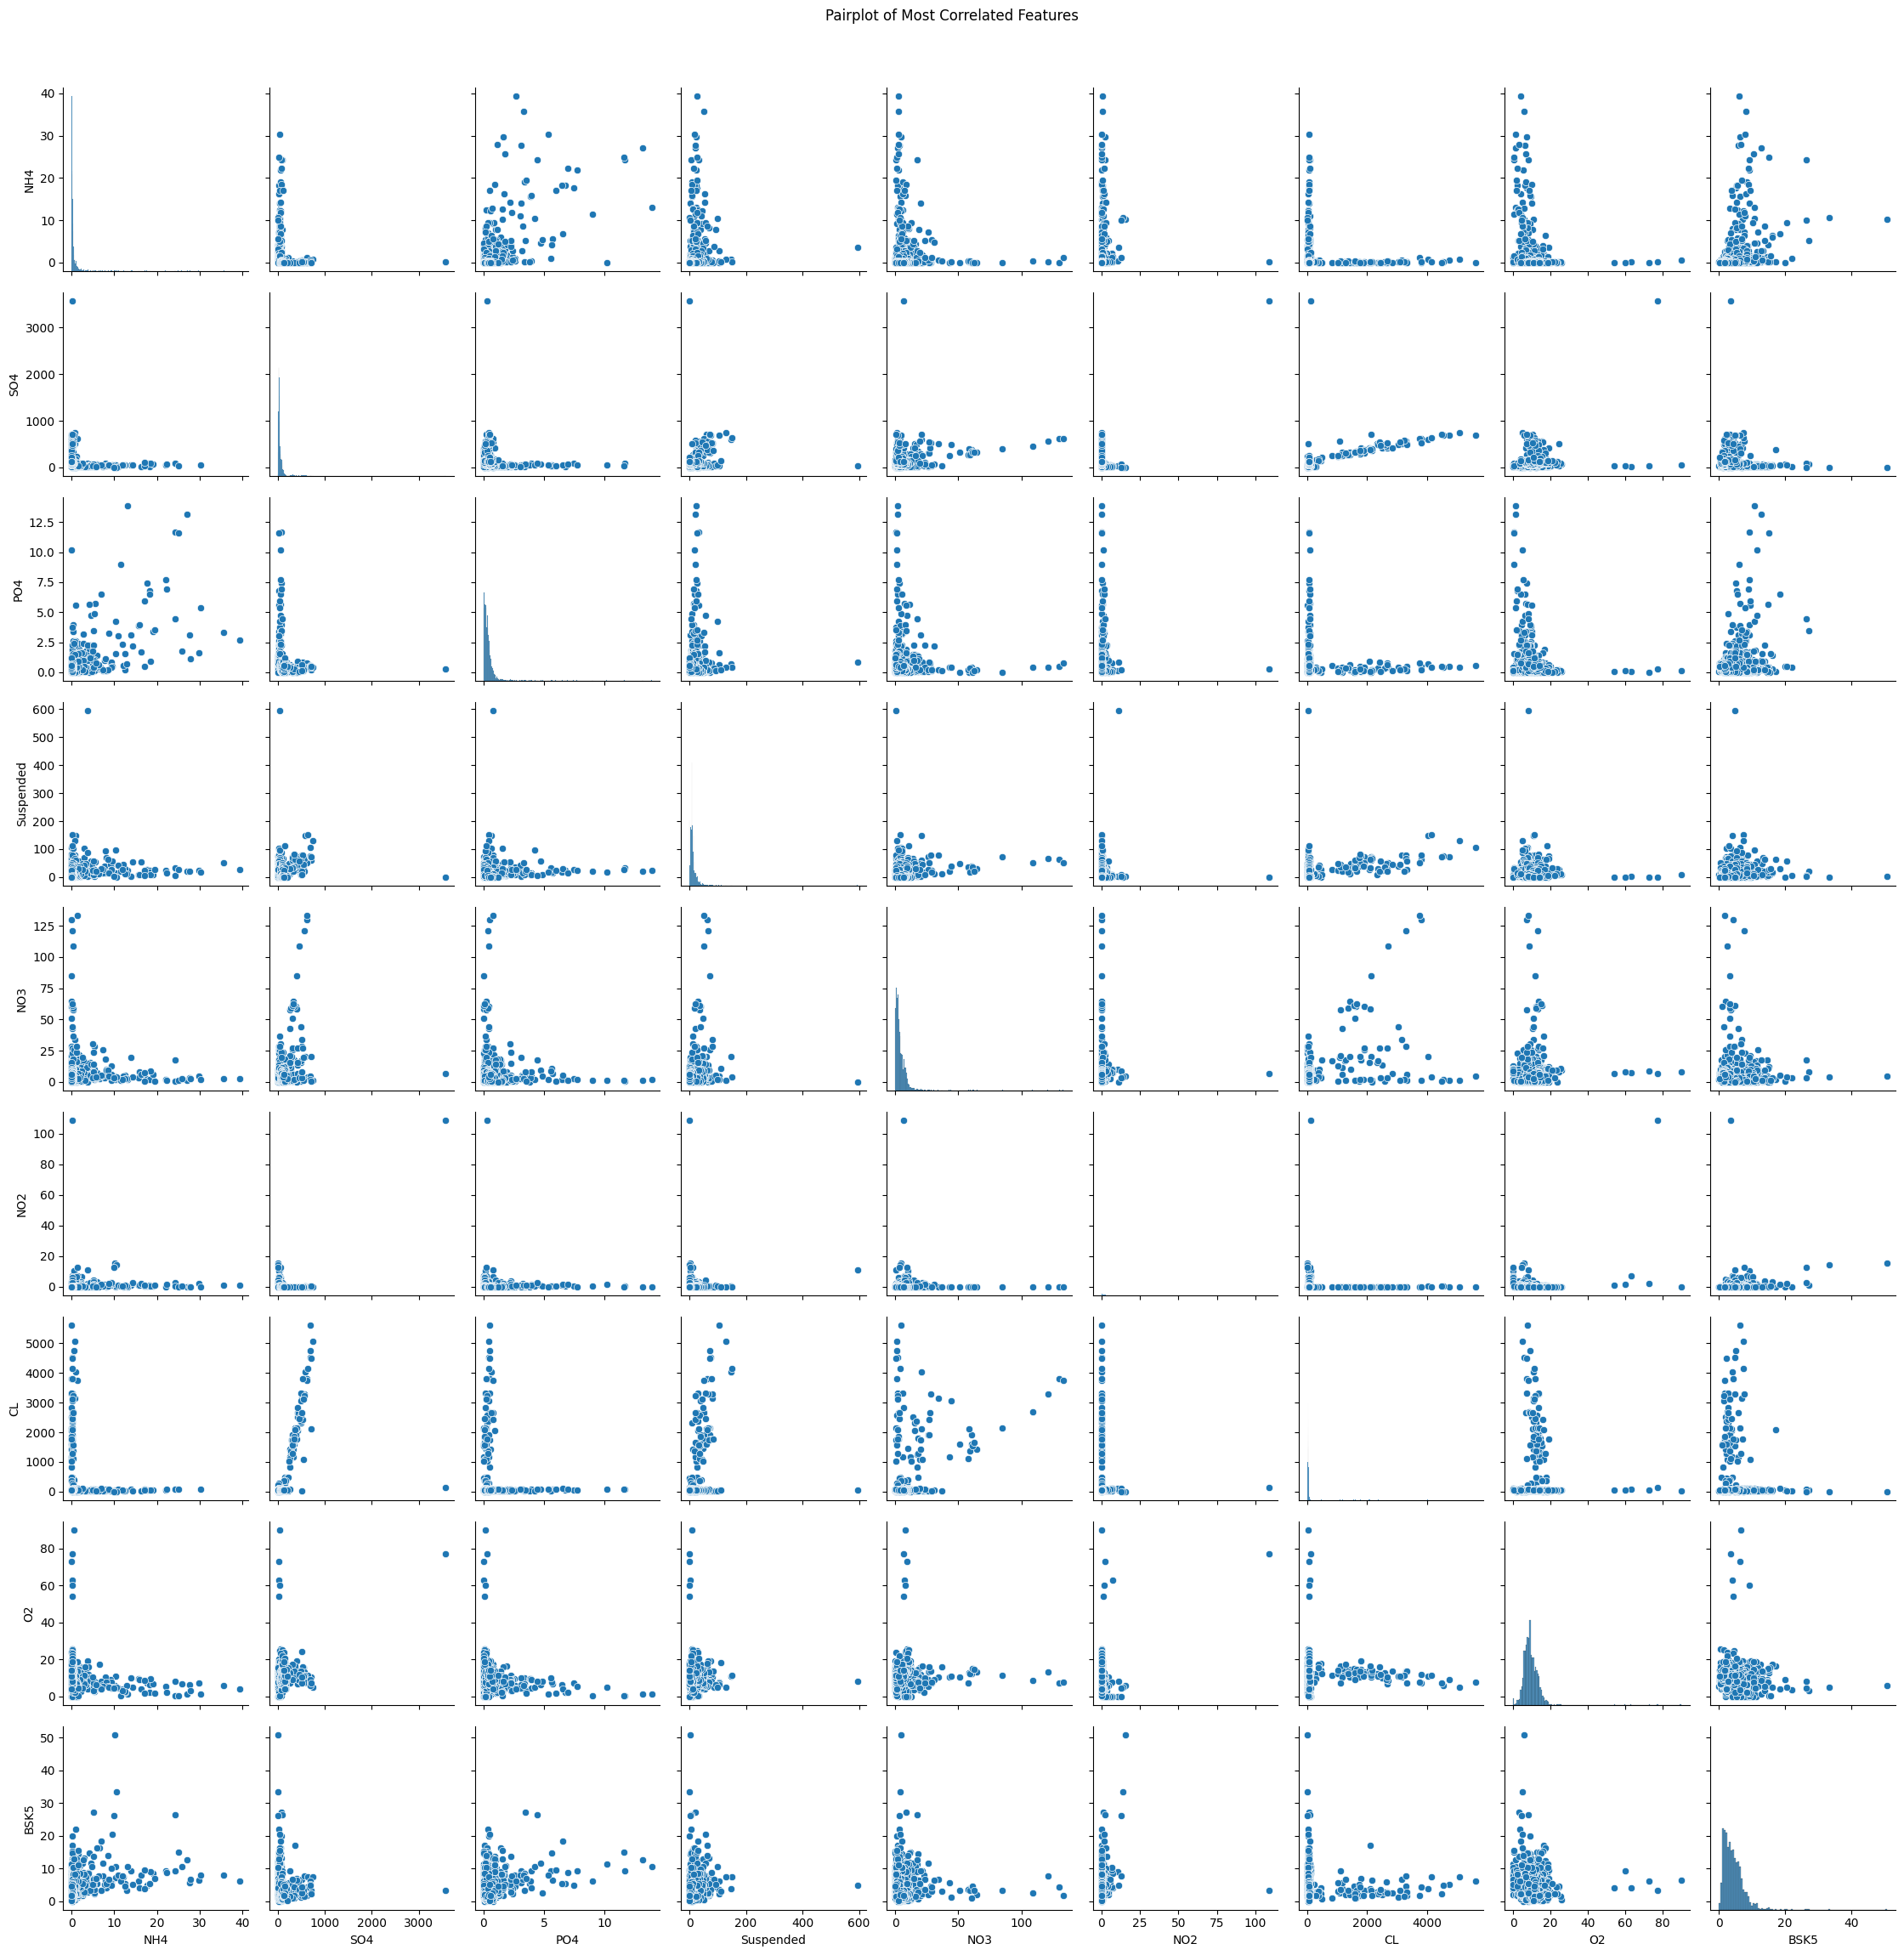

In [8]:
if len(TARGET_COLS) > 0:
    target_corr = corr[TARGET_COLS].abs().mean(axis=1).sort_values(ascending=False)
    top_features = target_corr.head(6).index.tolist()
    
    # Ensure we include target columns in the pairplot
    plot_cols = list(set(top_features + TARGET_COLS))
    
    # Create pairplot with existing columns only
    if len(plot_cols) > 1:
        sns.pairplot(df[plot_cols])
        plt.suptitle("Pairplot of Most Correlated Features", y=1.02)
        plt.tight_layout()
        plt.show()

In [6]:
print("Data types in the dataset:")
print(df.dtypes)
print("\n" + "="*50)

# Check for non-numeric columns that might contain dates or strings
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns found: {non_numeric_cols}")

# Function to check if a column contains dates
def is_date_column(col_name, sample_values):
    """Check if column contains date-like strings"""
    date_patterns = ['/', '.', '-']
    sample_str = str(sample_values.dropna().iloc[0]) if len(sample_values.dropna()) > 0 else ""
    return any(pattern in sample_str for pattern in date_patterns) and len(sample_str) > 5

# Process each non-numeric column
for col in non_numeric_cols:
    if col in TARGET_COLS:
        continue  # Skip target columns for now
    
    sample_values = df[col].head(10)
    print(f"\nColumn '{col}' sample values:")
    print(sample_values.tolist())
    
    if is_date_column(col, sample_values):
        print(f"'{col}' appears to be a date column. Converting to datetime and extracting features...")
        try:
            # Try to convert to datetime
            df[col + '_datetime'] = pd.to_datetime(df[col], errors='coerce')
            
            # Extract useful date features
            df[col + '_year'] = df[col + '_datetime'].dt.year
            df[col + '_month'] = df[col + '_datetime'].dt.month
            df[col + '_day'] = df[col + '_datetime'].dt.day
            df[col + '_dayofweek'] = df[col + '_datetime'].dt.dayofweek
            
            # Drop the original string column and datetime column
            df = df.drop(columns=[col, col + '_datetime'])
            print(f"✅ Converted '{col}' to date features (year, month, day, dayofweek)")
            
        except Exception as e:
            print(f"❌ Failed to convert '{col}' to datetime: {e}")
            # If conversion fails, drop the column
            df = df.drop(columns=[col])
            print(f"⚠️ Dropped column '{col}' due to conversion issues")
    else:
        # Try to convert to numeric, if fails, drop the column
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"✅ Converted '{col}' to numeric")
        except:
            print(f"⚠️ Dropping non-convertible column '{col}'")
            df = df.drop(columns=[col])

# Also check target columns for string values
print(f"\n" + "="*50)
print("Checking target columns for non-numeric values...")
for col in TARGET_COLS:
    if col in df.columns:
        # Try to convert target columns to numeric
        original_type = df[col].dtype
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Target '{col}': {original_type} -> {df[col].dtype}")

# Now prepare data for modeling
X = df.drop(columns=TARGET_COLS)
y = df[TARGET_COLS]

print(f"\nAfter preprocessing:")
print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

# Check for any remaining non-numeric columns
remaining_object_cols = X.select_dtypes(include=['object']).columns.tolist()
if remaining_object_cols:
    print(f"⚠️ Warning: Still have non-numeric columns: {remaining_object_cols}")
    print("Dropping these columns...")
    X = X.drop(columns=remaining_object_cols)
    print(f"Final feature matrix shape: {X.shape}")
else:
    print("✅ All feature columns are now numeric!")

Data types in the dataset:
id             int64
date          object
NH4          float64
BSK5         float64
Suspended    float64
O2           float64
NO3          float64
NO2          float64
SO4          float64
PO4          float64
CL           float64
dtype: object

Non-numeric columns found: ['date']

Column 'date' sample values:
['17.02.2000', '11.05.2000', '11.09.2000', '13.12.2000', '02.03.2001', '07.06.2001', '10.09.2001', '06.11.2001', '12.03.2002', '06.06.2002']
'date' appears to be a date column. Converting to datetime and extracting features...
✅ Converted 'date' to date features (year, month, day, dayofweek)

Checking target columns for non-numeric values...
Target 'NH4': float64 -> float64
Target 'BSK5': float64 -> float64
Target 'Suspended': float64 -> float64
Target 'O2': float64 -> float64
Target 'NO3': float64 -> float64
Target 'NO2': float64 -> float64
Target 'SO4': float64 -> float64
Target 'PO4': float64 -> float64
Target 'CL': float64 -> float64

After preproce

C:\Users\jeswa\AppData\Local\Temp\ipykernel_13412\3112319258.py:29: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col + '_datetime'] = pd.to_datetime(df[col], errors='coerce')


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Training set - Features: {X_train.shape}, Targets: {y_train.shape}")
print(f"Test set - Features: {X_test.shape}, Targets: {y_test.shape}")


Training set - Features: (2288, 5), Targets: (2288, 9)
Test set - Features: (573, 5), Targets: (573, 9)


In [8]:
print(f"Before cleaning:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_train data types: {X_train.dtypes.value_counts()}")

# Check for any infinite values
print(f"Infinite values in X_train: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Infinite values in y_train: {np.isinf(y_train.select_dtypes(include=[np.number])).sum().sum()}")

# Replace infinite values with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
y_test = y_test.replace([np.inf, -np.inf], np.nan)

# Find complete cases (no missing values in features or targets)
train_complete_mask = ~(X_train.isna().any(axis=1) | y_train.isna().any(axis=1))
X_train_clean = X_train[train_complete_mask]
y_train_clean = y_train[train_complete_mask]

test_complete_mask = ~(X_test.isna().any(axis=1) | y_test.isna().any(axis=1))
X_test_clean = X_test[test_complete_mask]
y_test_clean = y_test[test_complete_mask]

print(f"\nAfter cleaning:")
print(f"X_train_clean shape: {X_train_clean.shape}, y_train_clean shape: {y_train_clean.shape}")
print(f"X_test_clean shape: {X_test_clean.shape}, y_test_clean shape: {y_test_clean.shape}")

if len(X_train_clean) == 0:
    raise ValueError("No complete cases found for training!")

if len(X_test_clean) == 0:
    raise ValueError("No complete cases found for testing!")

# Final check - ensure all data is numeric
print(f"\nFinal data type check:")
print(f"X_train_clean dtypes: {X_train_clean.dtypes.value_counts()}")
print(f"y_train_clean dtypes: {y_train_clean.dtypes.value_counts()}")

# Check for any remaining non-numeric data
for col in X_train_clean.columns:
    if X_train_clean[col].dtype == 'object':
        print(f"⚠️ Warning: Column '{col}' is still object type")
        print(f"Sample values: {X_train_clean[col].head()}")

print("✅ Data cleaning completed!")

Before cleaning:
X_train shape: (2288, 5), y_train shape: (2288, 9)
X_train data types: int32    4
int64    1
Name: count, dtype: int64
Infinite values in X_train: 0
Infinite values in y_train: 0

After cleaning:
X_train_clean shape: (2221, 5), y_train_clean shape: (2221, 9)
X_test_clean shape: (555, 5), y_test_clean shape: (555, 9)

Final data type check:
X_train_clean dtypes: int32    4
int64    1
Name: count, dtype: int64
y_train_clean dtypes: float64    9
Name: count, dtype: int64
✅ Data cleaning completed!


In [9]:
base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
multi_rf = MultiOutputRegressor(base_rf)

# Hyperparameter tuning
param_dist = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [None, 10, 20],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2],
    "estimator__max_features": ["sqrt", "log2"],
}

print("Starting hyperparameter tuning...")
search = RandomizedSearchCV(
    estimator=multi_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)


Starting hyperparameter tuning...


In [10]:
search.fit(X_train_clean, y_train_clean)
print("✅ Model training completed successfully!")

# Get the best model
best_model = search.best_estimator_
print(f"🏆 Best parameters: {search.best_params_}")

# Save the model
joblib.dump(best_model, "best_rf_multioutput.pkl")
print("📄 Model saved as 'best_rf_multioutput.pkl'")

# Save the feature column names for use in the Streamlit app
feature_columns = list(X_train_clean.columns)
joblib.dump(feature_columns, "model_columns.pkl")
print(f"📄 Feature columns saved as 'model_columns.pkl'")
print(f"📋 Features used: {feature_columns}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Model training completed successfully!
🏆 Best parameters: {'estimator__n_estimators': 100, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'sqrt', 'estimator__max_depth': None}
📄 Model saved as 'best_rf_multioutput.pkl'
📄 Feature columns saved as 'model_columns.pkl'
📋 Features used: ['id', 'date_year', 'date_month', 'date_day', 'date_dayofweek']
✅ Model training completed successfully!
🏆 Best parameters: {'estimator__n_estimators': 100, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'sqrt', 'estimator__max_depth': None}
📄 Model saved as 'best_rf_multioutput.pkl'
📄 Feature columns saved as 'model_columns.pkl'
📋 Features used: ['id', 'date_year', 'date_month', 'date_day', 'date_dayofweek']


In [23]:
y_pred = best_model.predict(X_test_clean)

# Evaluate the model
r2 = r2_score(y_test_clean, y_pred, multioutput="uniform_average")
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))

print(f"\n📊 Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


📊 Model Performance:
R² Score: 0.4656
RMSE: 39.8193


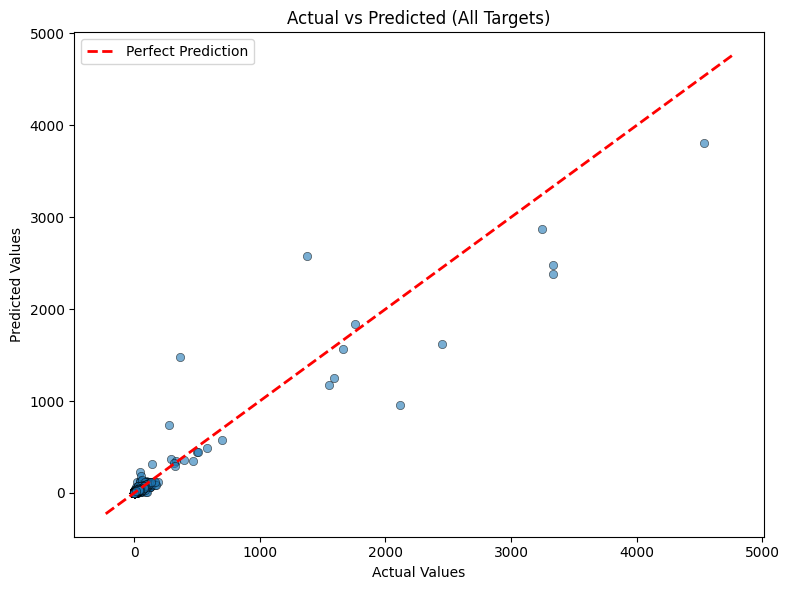

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    y_test_clean.values.flatten(),
    y_pred.flatten(),
    alpha=0.6,
    edgecolor="k",
    linewidth=0.5
)

# Perfect prediction line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, "r--", linewidth=2, label="Perfect Prediction")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.set_title("Actual vs Predicted (All Targets)")
ax.legend()
plt.tight_layout()
plt.show()


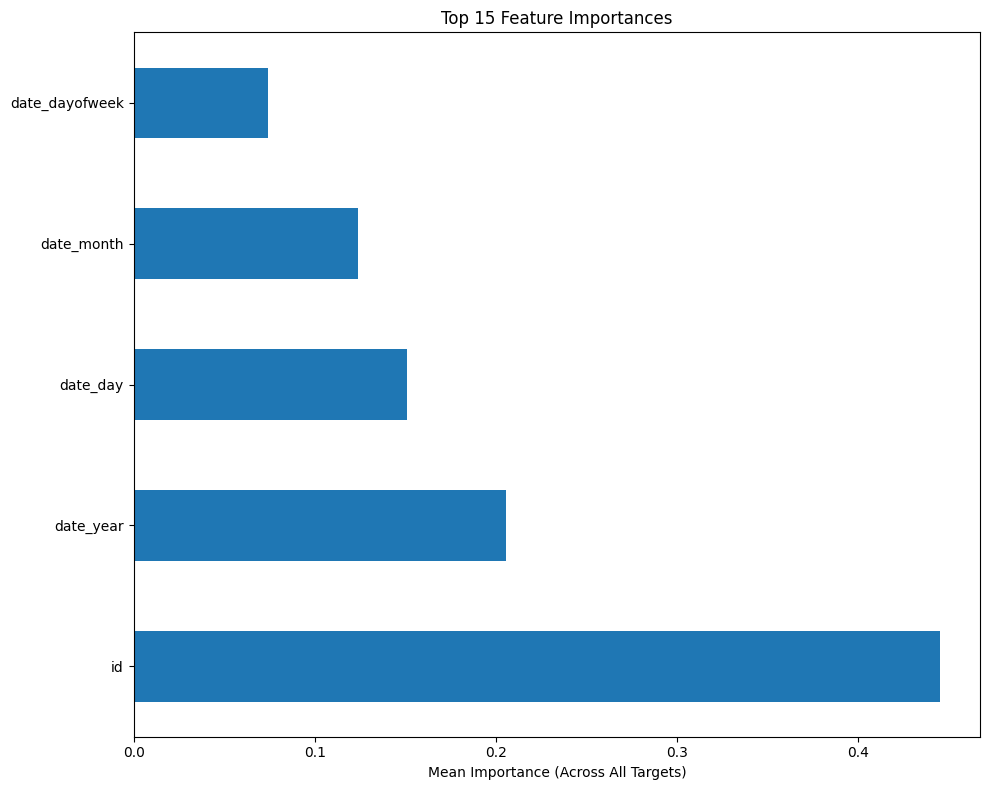


✅ Analysis completed successfully!


In [25]:
importances = np.mean(
    [estimator.feature_importances_ for estimator in best_model.estimators_], 
    axis=0
)

feat_imp = pd.Series(
    importances, 
    index=X_train_clean.columns
).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 8))
feat_imp.plot(kind='barh', ax=ax)
ax.set_title("Top 15 Feature Importances")
ax.set_xlabel("Mean Importance (Across All Targets)")
plt.tight_layout()
plt.show()

print("\n✅ Analysis completed successfully!")